# Notebook 01: Daten Laden und Explorieren

## Ziel dieses Notebooks

1. **MedSynth Dataset laden** - Von HuggingFace herunterladen
2. **Datenstruktur verstehen** - Felder, Typen, Beispiele
3. **Explorative Datenanalyse (EDA)** - Statistiken und Visualisierungen
4. **ICD-10 Verteilung** - Häufigkeit der Diagnose-Codes
5. **Datenqualität prüfen** - Missing Values, Anomalien

---

## 1. Setup und Konfiguration

Die folgende Zelle enthält alle notwendigen Konfigurationen und Imports. Diese Konfiguration ist **identisch** zu Notebook 00 und macht dieses Notebook vollständig unabhängig.

In [4]:
# ============================================================
# SETUP: Imports und Umgebung
# ============================================================

import os
import json
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, Optional
from datetime import datetime

# Warnungen unterdrücken
warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PyTorch
import torch

# HuggingFace
from datasets import load_dataset, Dataset, DatasetDict

# Schönere Plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("Imports erfolgreich!")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA verfügbar: {torch.cuda.is_available()}")

Imports erfolgreich!
   PyTorch: 2.10.0+cu128
   CUDA verfügbar: True


In [5]:
# ============================================================
# KONFIGURATION
# ============================================================

@dataclass
class PathConfig:
    """Alle Pfade für das Projekt."""
    project_root: Path = field(default_factory=lambda: Path.cwd().parent)
    data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data")
    cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "cache")
    models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models")
    finetuned_models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models" / "finetuned")
    outputs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs")
    logs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "logs")
    plots_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "plots")
    reports_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "reports")
    predictions_cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "cache" / "predictions")
    
    def create_directories(self):
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Path) and not attr_name.startswith('_'):
                attr.mkdir(parents=True, exist_ok=True)

@dataclass
class DataConfig:
    """Konfiguration für Datenverarbeitung."""
    dataset_name: str = "Ahmad0067/MedSynth"
    dataset_split_seed: int = 42
    train_ratio: float = 0.70
    val_ratio: float = 0.15
    test_ratio: float = 0.15
    max_sequence_length: int = 2048
    truncation: bool = True
    padding: str = "max_length"
    batch_size: int = 128
    num_workers: int = 12

@dataclass
class Config:
    """Haupt-Konfiguration."""
    paths: PathConfig = field(default_factory=PathConfig)
    data: DataConfig = field(default_factory=DataConfig)
    
    def setup(self):
        self.paths.create_directories()

# Konfiguration erstellen
config = Config()
config.setup()

print("Konfiguration geladen!")
print(f"   Dataset: {config.data.dataset_name}")
print(f"   Cache-Dir: {config.paths.cache_dir}")

Konfiguration geladen!
   Dataset: Ahmad0067/MedSynth
   Cache-Dir: /home/bmw/src/simon/finetuning/data/cache


## 2. Dataset laden

Der **MedSynth-Datensatz** enthält synthetische Arzt-Patienten-Dialoge mit zugehörigen ICD-10 Codes. Er wurde speziell für das Training medizinischer NLP-Modelle erstellt.

Wir verwenden unseren eigenen `MedSynthDataLoader`, der den Datensatz von HuggingFace lädt.

**Herausforderungen an diesem Datenset:**
- Hohe Sequenzlängen (lange Texte)
- Extreme Klassnevielfalt

**Wichtige Funktionen:**
- `load()` - Läst den Datensatz
- `get_statistics()` - Berechnet Statistiken
- `preview()` - Zeigt Beispieldaten

In [6]:
# ============================================================
# DATA LOADER KLASSE
# ============================================================

class MedSynthDataLoader:
    """
    Lädt und verarbeitet den MedSynth-Datensatz.
    
    Der MedSynth-Datensatz enthält:
    - Arzt-Patienten-Dialoge (synthetisch generiert)
    - Chief Complaints (Hauptbeschwerde)
    - ICD-10 Diagnose-Codes
    - ICD-10 Beschreibungen
    """
    
    def __init__(self, dataset_name: str = "Ahmad0067/MedSynth", 
                 cache_dir: Optional[Path] = None):
        """
        Args:
            dataset_name: Name des HuggingFace-Datensatzes
            cache_dir: Verzeichnis für gecachte Daten
        """
        self.dataset_name = dataset_name
        self.cache_dir = cache_dir
        self.dataset = None
        
    def load(self) -> Dataset:
        """
        Lädt den Datensatz von HuggingFace Hub.
        
        Returns:
            Dataset: Geladener HuggingFace Dataset
        """
        print(f"Lade Dataset: {self.dataset_name}")
        
        # Lade von HuggingFace
        self.dataset = load_dataset(
            self.dataset_name,
            cache_dir=str(self.cache_dir) if self.cache_dir else None,
        )
        
        # Wenn DatasetDict, nimm 'train' Split
        if isinstance(self.dataset, DatasetDict):
            if "train" in self.dataset:
                self.dataset = self.dataset["train"]
            else:
                first_split = list(self.dataset.keys())[0]
                print(f"Kein 'train' Split, verwende '{first_split}'")
                self.dataset = self.dataset[first_split]
        
        print(f"Dataset geladen!")
        print(f"   Größe: {len(self.dataset):,} Samples")
        print(f"   Features: {list(self.dataset.features.keys())}")
        
        return self.dataset
    
    def get_sample(self, idx: int = 0) -> Dict:
        """Holt ein einzelnes Sample."""
        if self.dataset is None:
            raise ValueError("Dataset nicht geladen. Rufe load() auf.")
        return self.dataset[idx]
    
    def preview(self, n_samples: int = 5) -> pd.DataFrame:
        """Zeigt Preview als DataFrame."""
        if self.dataset is None:
            raise ValueError("Dataset nicht geladen.")
        samples = [self.dataset[i] for i in range(min(n_samples, len(self.dataset)))]
        return pd.DataFrame(samples)
    
    def get_statistics(self) -> Dict:
        """Berechnet Statistiken über den Datensatz."""
        if self.dataset is None:
            raise ValueError("Dataset nicht geladen.")
        
        stats = {
            "total_samples": len(self.dataset),
            "features": list(self.dataset.features.keys()),
        }
        
        # Finde Dialog-Feld
        dialog_field = None
        for field in ["Dialogue", "dialogue", "conversation", "text"]:
            if field in self.dataset.features:
                dialog_field = field
                break
        
        if dialog_field:
            # Berechne Längenstatistiken
            lengths = []
            for sample in tqdm(self.dataset, desc="Berechne Längen"):
                text = sample[dialog_field]
                if isinstance(text, str):
                    lengths.append(len(text.split()))
            
            stats["dialog_lengths"] = {
                "mean": np.mean(lengths),
                "min": np.min(lengths),
                "max": np.max(lengths),
                "median": np.median(lengths),
                "std": np.std(lengths),
            }
        
        # ICD-10 Analyse
        icd_field = None
        for field in ["ICD10", "icd10", "icd_code", "label"]:
            if field in self.dataset.features:
                icd_field = field
                break
        
        if icd_field:
            icd_codes = [sample[icd_field] for sample in self.dataset]
            unique_codes = set(icd_codes)
            stats["icd_codes"] = {
                "total_unique": len(unique_codes),
                "samples_per_code": len(self.dataset) / len(unique_codes),
            }
        
        return stats

print("MedSynthDataLoader definiert!")

MedSynthDataLoader definiert!


### Datenstruktur

Der Datensatz hat 10.240 Samples.
**Features:**
- `Dialogue`: Das Gespräch zwischen Arzt und Patient (Input)
- `Note`: Klinische Notizen (als Hilfsinput oder Ground Truth)
- `ICD10` `ICD10_desc`: Diagnosecode und dessen Beschreibung (Target/Label)

In [7]:
# ============================================================
# DATASET LADEN
# ============================================================

# DataLoader erstellen
data_loader = MedSynthDataLoader(
    dataset_name=config.data.dataset_name,
    cache_dir=config.paths.cache_dir
)

# Dataset laden
dataset = data_loader.load()

Lade Dataset: Ahmad0067/MedSynth
Dataset geladen!
   Größe: 10,240 Samples
   Features: [' Note', 'Dialogue', 'ICD10', 'ICD10_desc']


## 3. Datenstruktur analysieren

In [8]:
# ============================================================
# DATENSTRUKTUR ANALYSIEREN
# ============================================================

print("Dataset Features:")
print("=" * 60)
for feature_name, feature_type in dataset.features.items():
    print(f"   {feature_name}: {feature_type}")

print(f"\nDataset Größe: {len(dataset):,} Samples")

Dataset Features:
    Note: Value('string')
   Dialogue: Value('string')
   ICD10: Value('string')
   ICD10_desc: Value('string')

Dataset Größe: 10,240 Samples


In [9]:
# ============================================================
# BEISPIEL-SAMPLE ANZEIGEN
# ============================================================

print("Beispiel-Sample (Index 0):")
print("=" * 60)

sample = data_loader.get_sample(0)

for key, value in sample.items():
    print(f"\n{key}:")
    if isinstance(value, str) and len(value) > 200:
        print(f"   {value[:200]}...")
    else:
        print(f"   {value}")

Beispiel-Sample (Index 0):

 Note:
   **1. Subjective:**

   **Chief Complaint (CC):**
   - Pain in the left knee, moderate to severe, lasting for 3 weeks.

   **History of Present Illness (HPI):**
   - The patient, a 52-year-old Caucasia...

Dialogue:
   [doctor]: Hello! It’s good to see you today. How can I help you?

[patient]: Hi, Doctor. I’ve been having a lot of pain in my left knee.

[doctor]: I’m sorry to hear that. Can you tell me more about t...

ICD10:
   M25562

ICD10_desc:
   PAIN IN LEFT KNEE


In [10]:
# ============================================================
# PREVIEW ALS DATAFRAME
# ============================================================

print("Preview (erste 5 Samples):")
preview_df = data_loader.preview(5)
display(preview_df)

Preview (erste 5 Samples):


,Note,Dialogue,ICD10,ICD10_desc
0,**1. Subjective:**\n\n **Chief Complaint (CC...,[doctor]: Hello! It’s good to see you today. H...,M25562,PAIN IN LEFT KNEE
1,**1. Subjective:**\n\n - **Chief Complaint (...,"[doctor] Hi there, how are you today?\n\n[pati...",M25562,PAIN IN LEFT KNEE
2,**1. Subjective:**\n\n**Chief Complaint (CC):*...,"[doctor] Good morning, how are you doing today...",M25562,PAIN IN LEFT KNEE
3,**1. Subjective:**\n\n**Chief Complaint (CC):*...,[doctor] Good morning! How are you feeling tod...,M25562,PAIN IN LEFT KNEE
4,#####\n**1. Subjective:**\n\n**Chief Complaint...,"[doctor]: Hello Mr. Doe, how are you doing tod...",M25562,PAIN IN LEFT KNEE


## 4. Explorative Datenanalyse (EDA)

In [11]:
# ============================================================
# STATISTIKEN BERECHNEN
# ============================================================

print("Berechne Dataset-Statistiken...")
stats = data_loader.get_statistics()

print("\nDataset-Statistiken:")
print("=" * 60)
print(f"   Gesamtzahl Samples: {stats['total_samples']:,}")
print(f"   Features: {stats['features']}")

if 'dialog_lengths' in stats:
    dl = stats['dialog_lengths']
    print(f"\nDialog-Längen (in Wörtern):")
    print(f"   Mittelwert: {dl['mean']:.1f}")
    print(f"   Median: {dl['median']:.1f}")
    print(f"   Min: {dl['min']}")
    print(f"   Max: {dl['max']}")
    print(f"   Standardabweichung: {dl['std']:.1f}")

if 'icd_codes' in stats:
    icd = stats['icd_codes']
    print(f"\nICD-10 Codes:")
    print(f"   Unique Codes: {icd['total_unique']}")
    print(f"   Samples pro Code: {icd['samples_per_code']:.1f}")

Berechne Dataset-Statistiken...


Berechne Längen: 100%|██████████| 10240/10240 [00:00<00:00, 25331.43it/s]



Dataset-Statistiken:
   Gesamtzahl Samples: 10,240
   Features: [' Note', 'Dialogue', 'ICD10', 'ICD10_desc']

Dialog-Längen (in Wörtern):
   Mittelwert: 731.3
   Median: 725.0
   Min: 304
   Max: 2705
   Standardabweichung: 104.0

ICD-10 Codes:
   Unique Codes: 2037
   Samples pro Code: 5.0


Berechne Längen: 100%|██████████| 10240/10240 [00:00<00:00, 25784.00it/s]


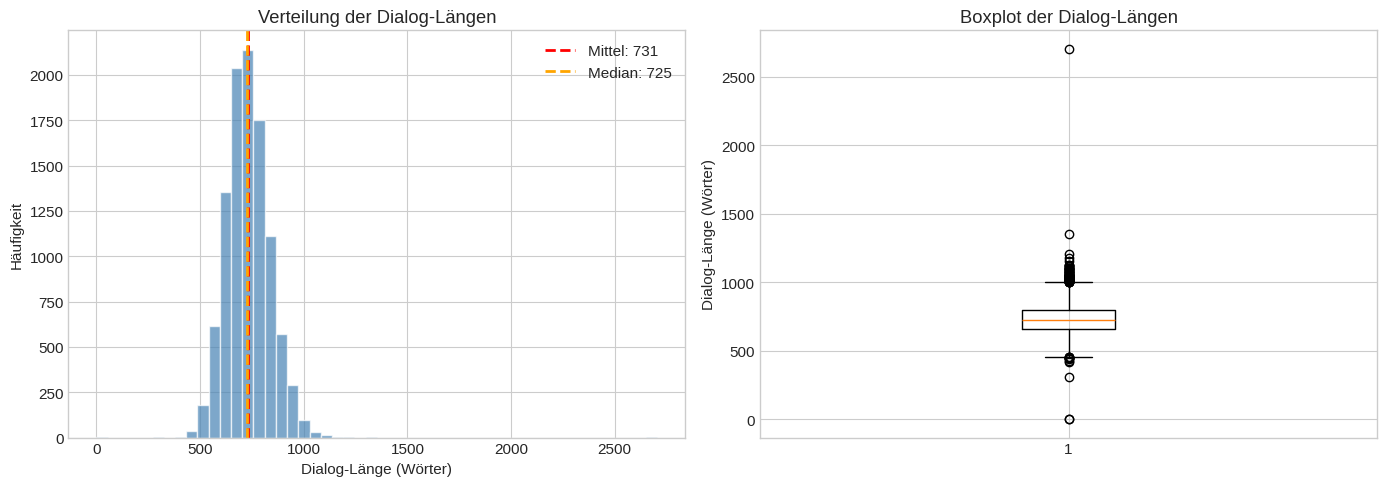

Plot gespeichert: /home/bmw/src/simon/finetuning/outputs/plots/dialog_lengths.png


In [12]:
# ============================================================
# DIALOG-LÄNGEN VISUALISIEREN
# ============================================================

# Finde Dialog-Feld
dialog_field = 'Dialogue' if 'Dialogue' in dataset.features else 'dialogue'

# Berechne Längen
dialog_lengths = [len(sample[dialog_field].split()) if isinstance(sample[dialog_field], str) and sample[dialog_field] else 0 for sample in tqdm(dataset, desc="Berechne Längen")]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramm
axes[0].hist(dialog_lengths, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(np.mean(dialog_lengths), color='red', linestyle='--', linewidth=2, label=f'Mittel: {np.mean(dialog_lengths):.0f}')
axes[0].axvline(np.median(dialog_lengths), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(dialog_lengths):.0f}')
axes[0].set_xlabel('Dialog-Länge (Wörter)')
axes[0].set_ylabel('Häufigkeit')
axes[0].set_title('Verteilung der Dialog-Längen')
axes[0].legend()

# Boxplot
axes[1].boxplot(dialog_lengths, vert=True)
axes[1].set_ylabel('Dialog-Länge (Wörter)')
axes[1].set_title('Boxplot der Dialog-Längen')

plt.tight_layout()
plt.savefig(config.paths.plots_dir / 'dialog_lengths.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot gespeichert: {config.paths.plots_dir / 'dialog_lengths.png'}")

## 5. ICD-10 Code Analyse

Die Verteilung der ICD-10 Codes ist wichtig für
- **CLass Imbalance:** Sind manche Diagnosen überrepräsentiert?
- **Modell-Performance:** Seltene Codes sind schwerer zu lernen
- **Evaluation:** Gewichtete Metriken könnten nötig sein

In [13]:
# ============================================================
# ICD-10 CODES EXTRAHIEREN
# ============================================================

# Finde ICD-Feld
icd_field = 'ICD10' if 'ICD10' in dataset.features else 'icd10'

# Extrahiere alle ICD-Codes
icd_codes = [sample[icd_field] for sample in dataset]

# Zähle Häufigkeiten
from collections import Counter
icd_counter = Counter(icd_codes)

print(f"ICD-10 Code Analyse:")
print("=" * 60)
print(f"   Gesamtzahl Codes: {len(icd_codes):,}")
print(f"   Unique Codes: {len(icd_counter)}")
print(f"\nTop 10 häufigste Codes:")
for code, count in icd_counter.most_common(10):
    print(f"   {code}: {count:,} ({count/len(icd_codes)*100:.1f}%)")

ICD-10 Code Analyse:
   Gesamtzahl Codes: 10,240
   Unique Codes: 2037

Top 10 häufigste Codes:
   R9720: 10 (0.1%)
   R972: 10 (0.1%)
   Z98890: 10 (0.1%)
   Z9889: 10 (0.1%)
   E784: 10 (0.1%)
   E7849: 10 (0.1%)
   R3129: 10 (0.1%)
   R312: 10 (0.1%)
   N10: 10 (0.1%)
   R938: 10 (0.1%)


In [14]:
# ============================================================
# ICD-10 HAUPTKATEGORIEN ANALYSIEREN
# ============================================================

# Extrahiere Hauptkategorie (erster Buchstabe)
main_categories = [code[0] if code else 'X' for code in icd_codes]
category_counter = Counter(main_categories)

# ICD-10 Kategorien-Beschreibungen
icd_categories = {
    'A': 'Infektionskrankheiten',
    'B': 'Infektionskrankheiten',
    'C': 'Neubildungen (Krebs)',
    'D': 'Blutkrankheiten',
    'E': 'Stoffwechsel/Endokrin',
    'F': 'Psychische Störungen',
    'G': 'Nervensystem',
    'H': 'Auge/Ohr',
    'I': 'Kreislaufsystem',
    'J': 'Atmungssystem',
    'K': 'Verdauungssystem',
    'L': 'Haut',
    'M': 'Muskel-Skelett',
    'N': 'Urogenitalsystem',
    'O': 'Schwangerschaft',
    'P': 'Perinatal',
    'Q': 'Angeborene Fehlbildungen',
    'R': 'Symptome/Abnorme Befunde',
    'S': 'Verletzungen',
    'T': 'Verletzungen/Vergiftungen',
    'U': 'Spezielle Codes',
    'V': 'Äußere Ursachen',
    'W': 'Äußere Ursachen',
    'X': 'Äußere Ursachen',
    'Y': 'Äußere Ursachen',
    'Z': 'Faktoren/Gesundheitszustand',
}

print("ICD-10 Hauptkategorien:")
print("=" * 60)
for cat, count in sorted(category_counter.items()):
    desc = icd_categories.get(cat, 'Unbekannt')
    print(f"   {cat} - {desc}: {count:,} ({count/len(icd_codes)*100:.1f}%)")

ICD-10 Hauptkategorien:
   A - Infektionskrankheiten: 65 (0.6%)
   B - Infektionskrankheiten: 160 (1.6%)
   C - Neubildungen (Krebs): 515 (5.0%)
   D - Blutkrankheiten: 385 (3.8%)
   E - Stoffwechsel/Endokrin: 405 (4.0%)
   F - Psychische Störungen: 500 (4.9%)
   G - Nervensystem: 355 (3.5%)
   H - Auge/Ohr: 435 (4.2%)
   I - Kreislaufsystem: 715 (7.0%)
   J - Atmungssystem: 530 (5.2%)
   K - Verdauungssystem: 635 (6.2%)
   L - Haut: 390 (3.8%)
   M - Muskel-Skelett: 1,155 (11.3%)
   N - Urogenitalsystem: 570 (5.6%)
   O - Schwangerschaft: 325 (3.2%)
   P - Perinatal: 30 (0.3%)
   Q - Angeborene Fehlbildungen: 25 (0.2%)
   R - Symptome/Abnorme Befunde: 1,110 (10.8%)
   S - Verletzungen: 440 (4.3%)
   T - Verletzungen/Vergiftungen: 95 (0.9%)
   U - Spezielle Codes: 5 (0.0%)
   Z - Faktoren/Gesundheitszustand: 1,395 (13.6%)


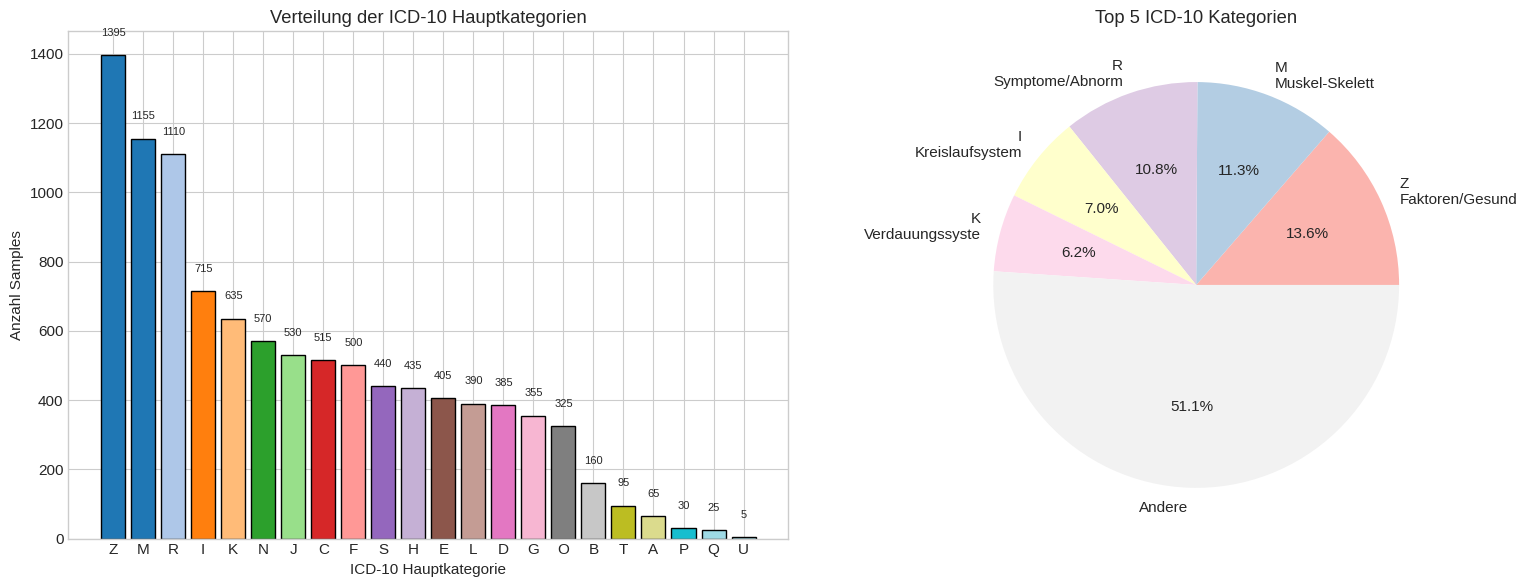

Plot gespeichert: /home/bmw/src/simon/finetuning/outputs/plots/icd10_distribution.png


In [15]:
# ============================================================
# VISUALISIERUNG: ICD-10 KATEGORIEN
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Balkendiagramm der Hauptkategorien
sorted_cats = sorted(category_counter.items(), key=lambda x: x[1], reverse=True)
cats = [c[0] for c in sorted_cats]
counts = [c[1] for c in sorted_cats]

colors = plt.cm.tab20(np.linspace(0, 1, len(cats)))
bars = axes[0].bar(cats, counts, color=colors, edgecolor='black')
axes[0].set_xlabel('ICD-10 Hauptkategorie')
axes[0].set_ylabel('Anzahl Samples')
axes[0].set_title('Verteilung der ICD-10 Hauptkategorien')

# Werte auf Balken
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{count}', ha='center', va='bottom', fontsize=8)

# Pie Chart der Top 5
top5 = category_counter.most_common(5)
other_count = sum(count for cat, count in category_counter.items() 
                  if cat not in [c[0] for c in top5])
pie_data = [c[1] for c in top5] + [other_count]
pie_labels = [f"{c[0]}\n{icd_categories.get(c[0], '')[:15]}" for c in top5] + ['Andere']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
            colors=plt.cm.Pastel1(np.linspace(0, 1, len(pie_data))))
axes[1].set_title('Top 5 ICD-10 Kategorien')

plt.tight_layout()
plt.savefig(config.paths.plots_dir / 'icd10_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot gespeichert: {config.paths.plots_dir / 'icd10_distribution.png'}")

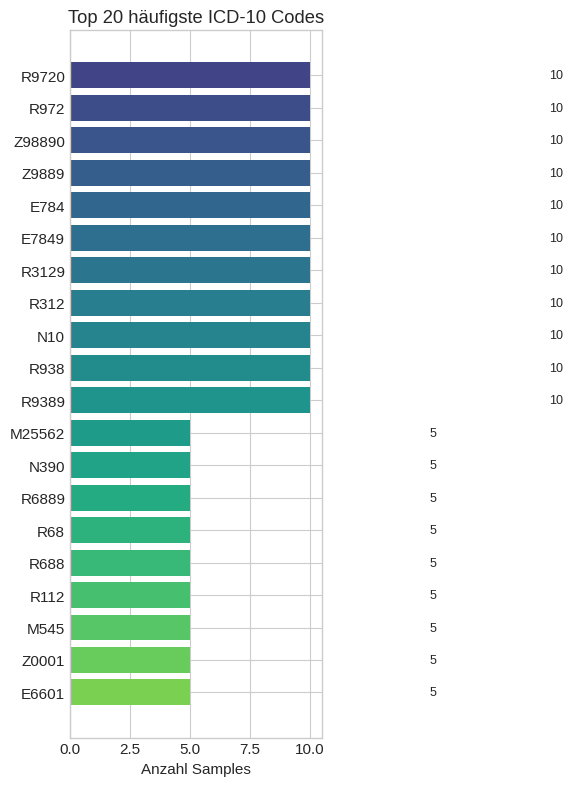

In [16]:
# ============================================================
# TOP 20 SPEZIFISCHE ICD-10 CODES
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))

top20 = icd_counter.most_common(20)
codes = [c[0] for c in top20]
counts = [c[1] for c in top20]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(codes)))
bars = ax.barh(range(len(codes)), counts, color=colors)
ax.set_yticks(range(len(codes)))
ax.set_yticklabels(codes)
ax.set_xlabel('Anzahl Samples')
ax.set_title('Top 20 häufigste ICD-10 Codes')
ax.invert_yaxis()

# Werte auf Balken
for bar, count in zip(bars, counts):
    ax.text(count + 10, bar.get_y() + bar.get_height()/2,
            f'{count}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(config.paths.plots_dir / 'top20_icd10.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Datenqualität prüfen

In [17]:
# ============================================================
# DATENQUALITÄT PRÜFEN
# ============================================================

print("Datenqualitäts-Check:")
print("=" * 60)

# Prüfe auf Missing Values
missing_counts = {}
for feature in dataset.features:
    missing = sum(1 for sample in dataset if not sample[feature])
    missing_counts[feature] = missing
    if missing > 0:
        print(f"   {feature}: {missing} leere Werte ({missing/len(dataset)*100:.2f}%)")

if all(v == 0 for v in missing_counts.values()):
    print("   Keine fehlenden Werte gefunden!")

def fix_icd_format(code):
    # 1. Convert to string, strip whitespace, and uppercase
    if pd.isna(code): return code
    s_code = str(code).strip().upper()
    
    # 2. If it already has a dot or is 3 chars or less, leave it alone
    if '.' in s_code or len(s_code) <= 3:
        return s_code
        
    # 3. Insert dot after the 3rd character
    return s_code[:3] + "." + s_code[3:]

icd_codes = [fix_icd_format(code) for code in icd_codes]

# Prüfe ICD-10 Format
print(f"\nICD-10 Format-Check:")
import re
icd_pattern = r"^[A-TV-Z][0-9][A-TV-Z0-9](?:\.[A-TV-Z0-9]{1,4})?$"
valid_codes = sum(1 for code in icd_codes if re.match(icd_pattern, code))
print(f"   Gültige ICD-10 Codes: {valid_codes:,} / {len(icd_codes):,} ({valid_codes/len(icd_codes)*100:.1f}%)")

# Zeige ungültige Codes (wenn vorhanden)
invalid_codes = [code for code in icd_codes if not re.match(icd_pattern, code)]
if invalid_codes:
    print(f"   Ungültige Codes (Beispiele): {list(set(invalid_codes))[:5]}")
else:
    print("   Alle ICD-10 Codes haben gültiges Format!")

print("Beispiele ungültiger ICD-10 Codes:")
for code in list(set(invalid_codes)):
    print(code)

Datenqualitäts-Check:
   Dialogue: 2 leere Werte (0.02%)

ICD-10 Format-Check:
   Gültige ICD-10 Codes: 10,235 / 10,240 (100.0%)
   Ungültige Codes (Beispiele): ['U07.1']
Beispiele ungültiger ICD-10 Codes:
U07.1


In [ ]:
# ============================================================
# DIALOG-QUALITÄT PRÜFEN
# ============================================================

from transformers import AutoTokenizer
from tqdm import tqdm

model_checkpoint = "NousResearch/Llama-2-7b-hf"
print(f"Lade Tokenizer: {model_checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def count_tokens(text):
    if not text: return 0
    return len(tokenizer.encode(text, add_special_tokens=False))

dialog_field = 'Dialogue'

print("Berechne Token-Längen...")
token_lengths = [count_tokens(sample[dialog_field]) for sample in tqdm(dataset, desc="Tokenizing")]

# Statistiken ausgeben
print(f"\nToken-Statistiken (für {model_checkpoint}):")
print(f"   Mittelwert: {np.mean(token_lengths):.1f} Tokens")
print(f"   Median: {np.median(token_lengths):.1f} Tokens")
print(f"   Max: {np.max(token_lengths)} Tokens")
print(f"   95. Perzentil: {np.percentile(token_lengths, 95):.1f} Tokens")

# Check gegen Config Limit
limit = config.data.max_sequence_length # z.B. 512
truncated_count = sum(1 for l in token_lengths if l > limit)
print(f"\nWARNUNG: {truncated_count} Samples ({truncated_count/len(dataset)*100:.1f}%) sind länger als {limit} Tokens und würden abgeschnitten werden!")

Lade Tokenizer: NousResearch/Llama-2-7b-hf
Berechne Token-Längen...


Tokenizing: 100%|██████████| 10240/10240 [00:09<00:00, 1053.74it/s]


Token-Statistiken (für NousResearch/Llama-2-7b-hf):
   Mittelwert: 1350.1 Tokens
   Median: 1337.0 Tokens
   Max: 5392 Tokens
   95. Perzentil: 1675.0 Tokens

WARNUNG: 9 Samples (0.1%) sind länger als 2048 Tokens und würden abgeschnitten werden!
Dialog-Qualitäts-Check:
   Sehr kurze Dialoge (<20 Wörter): 2 (0.02%)
   Sehr lange Dialoge (>500 Wörter): 10175 (99.37%)
   Durchschnittliche Länge: 731 Wörter
   Empfohlene max_sequence_length: 2048 Tokens
   Geschätzte durchschn. Token-Länge: 951 Tokens


## 7. Dataset speichern und Zusammenfassung

In [19]:
# ============================================================
# ZUSAMMENFASSUNG SPEICHERN
# ============================================================

summary = {
    "dataset_name": config.data.dataset_name,
    "total_samples": len(dataset),
    "features": list(dataset.features.keys()),
    "unique_icd_codes": len(icd_counter),
    "dialog_length_stats": {
        "mean": float(np.mean(dialog_lengths)),
        "median": float(np.median(dialog_lengths)),
        "min": int(np.min(dialog_lengths)),
        "max": int(np.max(dialog_lengths)),
        "std": float(np.std(dialog_lengths)),
    },
    "top10_icd_codes": dict(icd_counter.most_common(10)),
    "category_distribution": dict(category_counter),
    "generated_at": datetime.now().isoformat(),
}

# Speichern
summary_path = config.paths.reports_dir / "dataset_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Zusammenfassung gespeichert: {summary_path}")

Zusammenfassung gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/dataset_summary.json


In [20]:
# ============================================================
# FINALE ZUSAMMENFASSUNG
# ============================================================

print("=" * 60)
print("ZUSAMMENFASSUNG: MedSynth Dataset")
print("=" * 60)
print(f"""Dataset erfolgreich geladen und analysiert!

Übersicht:
   • Gesamtzahl Samples: {len(dataset):,}
   • Unique ICD-10 Codes: {len(icd_counter)}
   • Durchschnittliche Dialog-Länge: {np.mean(dialog_lengths):.0f} Wörter

Top 5 ICD-10 Kategorien:
""")
for cat, count in category_counter.most_common(5):
    desc = icd_categories.get(cat, 'Unbekannt')
    print(f"   • {cat} ({desc}): {count:,} Samples")

print(f"""
Gespeicherte Dateien:
   - {config.paths.plots_dir / 'dialog_lengths.png'}
   - {config.paths.plots_dir / 'icd10_distribution.png'}
   - {config.paths.plots_dir / 'top20_icd10.png'}
   - {config.paths.reports_dir / 'dataset_summary.json'}

Nächster Schritt: Notebook 02 - Datenverarbeitung und Tokenisierung
""")

ZUSAMMENFASSUNG: MedSynth Dataset
Dataset erfolgreich geladen und analysiert!

Übersicht:
   • Gesamtzahl Samples: 10,240
   • Unique ICD-10 Codes: 2037
   • Durchschnittliche Dialog-Länge: 731 Wörter

Top 5 ICD-10 Kategorien:

   • Z (Faktoren/Gesundheitszustand): 1,395 Samples
   • M (Muskel-Skelett): 1,155 Samples
   • R (Symptome/Abnorme Befunde): 1,110 Samples
   • I (Kreislaufsystem): 715 Samples
   • K (Verdauungssystem): 635 Samples

Gespeicherte Dateien:
   - /home/bmw/src/simon/finetuning/outputs/plots/dialog_lengths.png
   - /home/bmw/src/simon/finetuning/outputs/plots/icd10_distribution.png
   - /home/bmw/src/simon/finetuning/outputs/plots/top20_icd10.png
   - /home/bmw/src/simon/finetuning/outputs/reports/dataset_summary.json

Nächster Schritt: Notebook 02 - Datenverarbeitung und Tokenisierung

